## Importing Libraries

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from transformers import AutoTokenizer,AutoModel

# Load the BERT tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained('sileod/deberta-v3-base-tasksource-nli', do_lower_case=True)

Loading tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

## Setting up data

In [10]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/train_claims_quantemp.json") as f:
  train_data = json.load(f)
len(train_data)

9935

In [11]:
train_data[-1]

{'crawled_date': '2014-03-26T10:38:09',
 'country_of_origin': 'ukraine',
 'label': 'False',
 'url': 'https://www.stopfake.org/en/fake-commandos-from-berkut-who-refused-to-kneel-have-been-burned-alive-in-lviv/',
 'lang': 'en',
 'claim': 'FAKE:  Commandos from &#8220;Berkut&#8221; who refused to kneel have been burned alive in Lviv',
 'doc': 'The Russian TV channel “Russia 1” aired a program called “Evil spirits of Maydan: mystic of Ukrainian mayhem”. The program, among other things, referred to the claim that two soldiers of “Berkut”, who refused to kneel in front of Lviv Maydan and recognize the current government, allegedly were burned alive. https://www.youtube.com/watch?v=SUDH0Qbjuao This was reported by the head of the so-called Russian community of Dnepropetrovsk Victor Trukhov. He says, two “Berkut” solders were put on their knees publicly and then burned in Lviv. However, contrary to this claim, a fire occured in Lviv on February 20, 2014 where people from security forces were c

In [12]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/val_claims_quantemp.json") as f:
  val_data = json.load(f)
len(val_data)

3084

In [13]:
val_data[-1]

{'crawled_date': '2022-10-06T21:00:06',
 'country_of_origin': 'usa',
 'label': 'True',
 'url': 'https://www.politifact.com/factchecks/2021/oct/28/randy-feenstra/biden-administration-predicted-liquid-fuel-cars-ou/',
 'lang': 'en',
 'claim': 'The Biden administration "published a study concluding 4 (of) 5 new cars on the road by 2050 will still require liquid fuels."',
 'doc': 'President Joe Biden was in Michigan’s auto industry hub on Oct. 5 when he said, "the whole world knows that the future of the auto industry is electric." Rep. Randy Feenstra, R-Iowa, had a quick response, writing on Twitter: ".@POTUS no it’s not — in fact, your own administration published a study concluding 4/5 new cars on the road by 2050 will still require liquid fuels ... "It’s past time Biden lives up to his promise to expand clean-burning #biofuels. Don’t mess with the RFS!" Feenstra is correct about the share of cars in the United States projected to use liquid fuels. The U.S. Energy Information Administrat

In [14]:
with open('/content/drive/MyDrive/TUDelft/NLP Group Project/data/test_claims_quantemp.json', 'r') as file:
    test_data = json.load(file)
len(test_data)

2495

# BM25

## BM25 Setup

In [15]:
pip install rank_bm25

ERROR: Operation cancelled by user


In [16]:
import re
from rank_bm25 import BM25Okapi

ModuleNotFoundError: No module named 'rank_bm25'

In [ ]:
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/corpus_evidence_unified.json") as f:
  document_corpus = json.load(f)

In [ ]:
def preprocess_text(text):
	text = text.lower()
	text = re.sub(r'\s\.\.\.', '', text)
	text = re.sub(r'\.', '', text)
	text = text.split(" ")
	return text

In [ ]:
corpus = list(document_corpus.values())
tokenized_corpus = []
for doc in corpus:
	tokenized_corpus.append(preprocess_text(doc))

bm25 = BM25Okapi(tokenized_corpus)

In [ ]:
# query = val_data[16]['claim']
# results = bm25.get_top_n(preprocess_text(query), corpus, n=5)

# print("Query\n",query)
# print("\nResults:")
# for result in results:
#   print(result)

In [ ]:
def get_features_oracle(data):
  features = []
  evidences = []

  for index, fact in enumerate(data):
    claim = fact["claim"]


    feature = "[Claim]:"+claim+"[Evidences]:"+fact["doc"]
    features.append(feature)
  return features

In [35]:
import concurrent.futures
import os
import json
from tqdm import tqdm

def process_claim(claim):
    """
    Processes a claim to generate a feature string by fetching top relevant evidences using the global BM25 object.
    """
    preprocessed_claim = preprocess_text(claim)
    results = bm25.get_top_n(preprocessed_claim, corpus, n=5)
    evidences = ' '.join(results)
    return "[Claim]:" + (' '.join(preprocessed_claim)) + "[Evidences]:" + evidences

def get_features(data, save_path, pick_up_from=None):
    """
    Processes a list of data to extract features using the global BM25 object.
    Each claim is processed in parallel using multiple threads.
    Progress is saved every 10 claims and can resume from a saved state using JSON format.
    """
    features = []
    start_index = 0


    # Check if we need to pick up from a previous state
    if pick_up_from:
        with open(pick_up_from, 'r') as file:
            features = json.load(file)
            start_index = len(features)  # Determine where to start processing
            print(f"Picking up from {start_index} claims")

    # Prepare to save progress every 10 claims
    def save_progress(features):
        with open(save_path, 'w') as file:
            json.dump(features, file, ensure_ascii=False, indent=2)

    # Using ThreadPoolExecutor to manage threads
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        # Creating futures for each remaining claim
        futures = {executor.submit(process_claim, data[idx]['claim']): idx for idx in range(start_index, len(data))}

        # Process completed futures and save progress intermittently
        for future in tqdm(concurrent.futures.as_completed(futures), total=len(data) - start_index, desc="Processing Claims"):
            index = futures[future]
            try:
                result = future.result()
                features.append(result)
                if (len(features) - start_index) % 10 == 0:
                    save_progress(features)
            except Exception as e:
                print(f"Error processing claim at index {index}: {str(e)}")

    # Save any remaining processed claims
    save_progress(features)

    return features


## Run BM25

In [36]:
train_features = get_features(train_data,
                              save_path = '/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/bm25_features_train_set.json',
                              pick_up_from='/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/bm25_features_train_set.json')
len(train_features)

Picking up from 9935 claims


Processing Claims: 0it [00:00, ?it/s]


9935

In [37]:
test_features = get_features(test_data,
                              save_path = '/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/bm25_features_test_set.json',
                              pick_up_from='/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/bm25_features_test_set.json')
len(test_features)

Picking up from 2495 claims


Processing Claims: 0it [00:00, ?it/s]


2495

In [38]:
val_features = get_features(val_data,
                              save_path = '/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/bm25_features_val_set.json',
                              pick_up_from='/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/bm25_features_val_set.json')
len(val_features)

Picking up from 3084 claims


Processing Claims: 0it [00:00, ?it/s]


3084

## Tokenize and save as .pt

In [39]:
from torch.utils.data import TensorDataset
from tqdm import tqdm
from transformers import AutoTokenizer
import torch
import os
from sklearn.preprocessing import LabelEncoder

def tokenize_and_save_dataset(features, labels, tokenizer_short_name, tokenizer_path, dataset_type, le=None):
    """
    Tokenizes the features and saves the dataset as a PyTorch TensorDataset.

    Args:
    features (list): List of feature strings to tokenize.
    labels (list): List of labels corresponding to the features.
    tokenizer_short_name (str): Short name for the tokenizer to use in the filename.
    tokenizer_path (str): Path or name of the tokenizer model.
    dataset_type (str): The type of dataset (train, val, or test) for naming the file.
    le (LabelEncoder, optional): A fitted LabelEncoder. If None, a new one will be created and fitted to the labels.
    """
    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, do_lower_case=True)

    input_ids = []
    attention_masks = []

    # Tokenize each feature
    for sent in tqdm(features, desc=f"Tokenizing {dataset_type} features"):
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=256,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    # Encode the labels
    if le is None:
        le = LabelEncoder()
        labels_final = le.fit_transform(labels)
    else:
        labels_final = le.transform(labels)
    labels_final = torch.tensor(labels_final)

    print("Size mismatch?", input_ids.shape[0] , attention_masks.shape[0] , labels_final.shape[0])

    # Create TensorDataset
    dataset = TensorDataset(input_ids, attention_masks, labels_final)

    # Save the dataset
    save_file = os.path.join('/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/', f"{dataset_type}_dataset_tokenized_by_{tokenizer_short_name}.pt")
    torch.save(dataset, save_file)
    print(f"{dataset_type.capitalize()} dataset saved to {save_file}")
    return le  # Return the fitted label encoder for reuse


### Roberta

In [ ]:
train_labels = [fact["label"] for fact in train_data]
le = tokenize_and_save_dataset(
    features=train_features,
    labels=train_labels,
    tokenizer_short_name='roberta',
    tokenizer_path='FacebookAI/roberta-large-mnli',
    dataset_type='train'
)
val_labels = [fact["label"] for fact in val_data]
tokenize_and_save_dataset(
    features=val_features,
    labels=val_labels,
    tokenizer_short_name='roberta',
    tokenizer_path='FacebookAI/roberta-large-mnli',
    dataset_type='val',
    le=le  # Use the fitted LabelEncoder from the training set
)
test_labels = [fact["label"] for fact in test_data]
tokenize_and_save_dataset(
    features=test_features,
    labels=test_labels,
    tokenizer_short_name='roberta',
    tokenizer_path='FacebookAI/roberta-large-mnli',
    dataset_type='test',
    le=le  # Use the fitted LabelEncoder from the training set
)

### Mdeberta

In [ ]:
train_labels = [fact["label"] for fact in train_data]
le = tokenize_and_save_dataset(
    features=train_features,
    labels=train_labels,
    tokenizer_short_name='mdeberta',
    tokenizer_path='MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7',
    dataset_type='train'
)
val_labels = [fact["label"] for fact in val_data]
tokenize_and_save_dataset(
    features=val_features,
    labels=val_labels,
    tokenizer_short_name='mdeberta',
    tokenizer_path='MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7',
    dataset_type='val',
    le=le  # Use the fitted LabelEncoder from the training set
)
test_labels = [fact["label"] for fact in test_data]
tokenize_and_save_dataset(
    features=test_features,
    labels=test_labels,
    tokenizer_short_name='mdeberta',
    tokenizer_path='MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7',
    dataset_type='test',
    le=le  # Use the fitted LabelEncoder from the training set
)


### Bart

In [ ]:
train_labels = [fact["label"] for fact in train_data]
le = tokenize_and_save_dataset(
    features=train_features,
    labels=train_labels,
    tokenizer_short_name='bart',
    tokenizer_path='facebook/bart-large-mnli',
    dataset_type='train'
)
val_labels = [fact["label"] for fact in val_data]
tokenize_and_save_dataset(
    features=val_features,
    labels=val_labels,
    tokenizer_short_name='bart',
    tokenizer_path='facebook/bart-large-mnli',
    dataset_type='val',
    le=le  # Use the fitted LabelEncoder from the training set
)
test_labels = [fact["label"] for fact in test_data]
tokenize_and_save_dataset(
    features=test_features,
    labels=test_labels,
    tokenizer_short_name='bart',
    tokenizer_path='facebook/bart-large-mnli',
    dataset_type='test',
    le=le  # Use the fitted LabelEncoder from the training set
)

### Deberta

In [40]:
train_labels = [fact["label"] for fact in train_data]
le = tokenize_and_save_dataset(
    features=train_features,
    labels=train_labels,
    tokenizer_short_name='deberta',
    tokenizer_path='sileod/deberta-v3-base-tasksource-nli',
    dataset_type='train'
)
val_labels = [fact["label"] for fact in val_data]
tokenize_and_save_dataset(
    features=val_features,
    labels=val_labels,
    tokenizer_short_name='deberta',
    tokenizer_path='sileod/deberta-v3-base-tasksource-nli',
    dataset_type='val',
    le=le  # Use the fitted LabelEncoder from the training set
)
test_labels = [fact["label"] for fact in test_data]
tokenize_and_save_dataset(
    features=test_features,
    labels=test_labels,
    tokenizer_short_name='deberta',
    tokenizer_path='sileod/deberta-v3-base-tasksource-nli',
    dataset_type='test',
    le=le  # Use the fitted LabelEncoder from the training set
)


Tokenizing train features:   0%|          | 0/9935 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing train features: 100%|██████████| 9935/9935 [00:14<00:00, 706.16it/s]


Size mismatch? 9935 9935 9935
Train dataset saved to /content/drive/MyDrive/TUDelft/NLP Group Project/bm25/train_dataset_tokenized_by_deberta.pt


Tokenizing val features:   0%|          | 0/3084 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing val features: 100%|██████████| 3084/3084 [00:03<00:00, 865.76it/s]


Size mismatch? 3084 3084 3084
Val dataset saved to /content/drive/MyDrive/TUDelft/NLP Group Project/bm25/val_dataset_tokenized_by_deberta.pt


Tokenizing test features:   0%|          | 0/2495 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing test features: 100%|██████████| 2495/2495 [00:03<00:00, 636.00it/s]


Size mismatch? 2495 2495 2495
Test dataset saved to /content/drive/MyDrive/TUDelft/NLP Group Project/bm25/test_dataset_tokenized_by_deberta.pt


LabelEncoder()


# Training setup

In [17]:
# Load the BM25 datasets from the file
dataset = torch.load('/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/train_dataset_tokenized_by_deberta.pt')
val_dataset = torch.load('/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/val_dataset_tokenized_by_deberta.pt')

print("Datasets loaded successfully.")

Datasets loaded successfully.


In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler(dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [19]:
from torch import nn
class MultiClassClassifier(nn.Module):
    def __init__(self, model_path, labels_count, hidden_dim=768, mlp_dim=500, extras_dim=100, dropout=0.1, freeze_bert=False):
        super().__init__()

        self.nlimodel = AutoModel.from_pretrained(model_path,output_hidden_states=True,output_attentions=True)

        self.dropout = nn.Dropout(dropout)
        self.mlp = nn.Sequential(
#             nn.Linear(hidden_dim, mlp_dim),
            # input is of shape [batch_size, 256, 768]
            nn.Linear(mlp_dim, hidden_dim),
            nn.ReLU(),
            # nn.Linear(mlp_dim, mlp_dim),
            # # nn.ReLU(),
            # # nn.Linear(mlp_dim, mlp_dim),
            # nn.ReLU(),
            nn.Linear(hidden_dim, labels_count)
        )
        '''
        hidden_dim = 1024
        mlp_dim=768
        extras_dim=140
        MLP Input Shape : torch.Size([16, 256, 768])

        nn linear - (in_features, out_features)

        nn linear1 = (1024, 768)
        0.weight torch.Size([768, 1024])
        0.bias torch.Size([768])
        2.weight torch.Size([3, 768])
        2.bias torch.Size([3])
        '''

        self.softmax = nn.LogSoftmax(dim=1)
        if freeze_bert:
            print("Freezing layers")
            for param in self.nlimodel.parameters():
                param.requires_grad = False

    def forward(self, tokens, masks):
#         Input IDs / Tokens : torch.Size([16, 256])
#         Masks : torch.Size([16, 256])

        output = self.nlimodel(tokens, attention_mask=masks)
        # output is a dictionary

        # output keys = dict_keys(['last_hidden_state', 'hidden_states', 'attentions'])
        # each hidden state has shape [batch_size, 256, 768]
        # OUTPUT OF ROBERTA IS [batch_size, 1024]
        # each attention mask has shape [batch_size, 12, 256, 256]



        '''
        # Approach that pools the last hidden state
        # [batch_size, 256, 768] -> [batch_size, 768]

        dropout_output = self.dropout(output["last_hidden_state"])
        dropout_output = torch.mean(dropout_output, dim=1)
        '''
        # [CLS] token is usually in the first position
        dropout_output = self.dropout(output["last_hidden_state"][:, 0, :])




        # concat_output = torch.cat((dropout_output, topic_emb), dim=1)
        # concat_output = self.dropout(concat_output)



        mlp_output = self.mlp(dropout_output)
        proba = self.softmax(mlp_output)

        return mlp_output

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Loads BertForSequenceClassification, the pretrained BERT model with a single
num_classes = 3
model = MultiClassClassifier('sileod/deberta-v3-base-tasksource-nli',num_classes, 1024,768,140,dropout=0.1,freeze_bert=False)

# model.load_state_dict(torch.load("model_bert_difficulty_prediction/model_weights"))

# Tell pytorch to run this model on the GPU.
model.cuda()


MultiClassClassifier(
  (nlimodel): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      

## Setting up training loop

In [21]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
from transformers import get_linear_schedule_with_warmup


epochs = 20

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs



In [23]:
len(train_dataloader)

621

In [24]:
1935 * 32

61920

In [25]:
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [26]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [29]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [30]:
for param in model.nlimodel.encoder.layer[0:5].parameters():
    param.requires_grad=False

In [31]:
loss_func = nn.CrossEntropyLoss()

# Training

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
early_stopping = EarlyStopping(patience=2, verbose=True)
# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_accuracy = 0
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questimport gensim.downloader as api
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        # skill_labels = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        probas = model(b_input_ids,b_input_mask)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        loss = loss_func(probas, b_labels)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        # scheduler.step()
        logits = probas.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)



    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)

        b_input_mask = batch[1].to(device)
        # b_poincare = batch[2].to(device)
        # b_difficulty = batch[3].to(device)
        b_labels = batch[2].to(device)
        # skill_labels = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.

          logits = model(b_input_ids,b_input_mask)

        # Accumulate the validation loss.
        loss = loss_func(logits, b_labels)
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    output_dir = f'/content/drive/MyDrive/TUDelft/NLP Group Project/deberta-bm25-outputs'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)
    tokenizer.save_pretrained(output_dir)
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    621.    Elapsed: 0:00:39.
  Batch    80  of    621.    Elapsed: 0:01:16.
  Batch   120  of    621.    Elapsed: 0:01:51.
  Batch   160  of    621.    Elapsed: 0:02:27.
  Batch   200  of    621.    Elapsed: 0:03:03.
  Batch   240  of    621.    Elapsed: 0:03:39.
  Batch   280  of    621.    Elapsed: 0:04:15.
  Batch   320  of    621.    Elapsed: 0:04:50.
  Batch   360  of    621.    Elapsed: 0:05:26.
  Batch   400  of    621.    Elapsed: 0:06:02.
  Batch   440  of    621.    Elapsed: 0:06:38.
  Batch   480  of    621.    Elapsed: 0:07:13.
  Batch   520  of    621.    Elapsed: 0:07:49.
  Batch   560  of    621.    Elapsed: 0:08:25.
  Batch   600  of    621.    Elapsed: 0:09:01.
 Train Accuracy: 0.58

  Average training loss: 0.98
  Training epcoh took: 0:09:20

Running Validation...
  Accuracy: 0.58
Validation loss decreased (inf --> 0.976753).  Saving model ...
  Validation Loss: 0.98
  Validation took: 0:01:07
Saving model

## Loading the model

If you have already trained the model, you can load the model with the weights, and directly use it for inference

In [ ]:
import json
with open("/content/drive/MyDrive/TUDelft/NLP Group Project/data/val_claims_quantemp.json") as f:
  val_data = json.load(f)
len(val_data)



In [ ]:
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/ecir_compnumfacts/tokenizer')

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/ecir_compnumfacts/model_roberta_large_oracle/model_weights"))
model.eval()

In [ ]:
loss_func = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)

correct = []
incorrect = []


for batch in validation_dataloader:


    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():

      logits = model(b_input_ids,b_input_mask)
      predicted_labels = torch.argmax(softmax(logits), dim=1)

      # Now, predicted labels is one hot encoded.
      for i in range(len(b_labels)):
        if (predicted_labels[i] != b_labels[i]):
          incorrect.append(tokenizer.decode(b_input_ids[i]))
        else:
          correct.append(tokenizer.decode(b_input_ids[i]))

In [ ]:
# Printing some correctly classified documents
correct[0]

In [ ]:
incorrect[23]

In [ ]:
correct_dump = json.dumps(correct, indent=4)

with open('deberta_v3_correct.json', 'w') as json_file:
    json_file.write(correct_dump)

In [ ]:
incorrect_dump = json.dumps(incorrect, indent=4)

with open('deberta_v3_incorrect.json', 'w') as json_file:
    json_file.write(incorrect_dump)

# Testing

## Run Test set

In [6]:
from torch.utils.data import DataLoader, RandomSampler

test_dataset = torch.load('/content/drive/MyDrive/TUDelft/NLP Group Project/bm25/test_dataset_tokenized_by_deberta.pt')
test_dataloader = DataLoader(
            test_dataset,
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = 16
        )

In [41]:
import torch
import json
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from collections import defaultdict, Counter

model = MultiClassClassifier('sileod/deberta-v3-base-tasksource-nli', labels_count=3, hidden_dim=1024, mlp_dim=768, extras_dim=140, dropout=0.1, freeze_bert=False)
# model.load_state_dict(torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/model_weights'))
model.load_state_dict(torch.load(f'/content/drive/MyDrive/TUDelft/NLP Group Project/deberta-bm25-outputs/model_weights'))

if torch.cuda.is_available():
    model.cuda()
    print("Model moved to GPU.")
else:
    print("GPU not available, using CPU.")

model.eval()

batch_size = 16

label_mapping = list(le.classes_)
# label_mapping = ["True", "False", "Conflicting"]

test_taxonomy_labels = [fact["taxonomy_label"] for fact in test_data]
print("test_taxonomy_labels", test_taxonomy_labels)

loss_func = nn.CrossEntropyLoss()
softmax = nn.Softmax(dim=1)

correct = []
incorrect = []
taxonomy_metrics = defaultdict(lambda: defaultdict(list))
overall_true_labels = []
overall_predictions = []

for i, batch in enumerate(tqdm(test_dataloader, desc="Evaluating")):
    batch = tuple(t.cuda() if torch.cuda.is_available() else t for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, b_input_mask)
        predicted_labels = torch.argmax(softmax(logits), dim=1)
          # Now, predicted labels is one hot encoded.
        start_index = i * batch_size
        for j in range(len(b_labels)):
          decoded_sentence = tokenizer.decode(b_input_ids[j], skip_special_tokens=True)
          true_label = label_mapping[b_labels[j].item()]
          predicted_label = label_mapping[predicted_labels[j].item()]
          taxonomy = test_taxonomy_labels[start_index + j]
          result_info = {
            "Tokenizer_decoded": decoded_sentence,
            "Ground_truth": true_label,
            "Predicted_as": predicted_label,
            "Taxonomy": taxonomy
          }
          if (predicted_labels[j] != b_labels[j]):
            incorrect.append(result_info)
          else:
            correct.append(result_info)
    # Store overall predictions and true labels for overall metrics
    overall_predictions.extend(predicted_labels.cpu().numpy())
    overall_true_labels.extend(b_labels.cpu().numpy())

    # Store predictions for each taxonomy
    start_index = i * batch_size
    for j in range(len(b_labels)):
        taxonomy = test_taxonomy_labels[start_index + j]
        taxonomy_metrics[taxonomy]['true'].append(b_labels[j].item())
        taxonomy_metrics[taxonomy]['pred'].append(predicted_labels[j].item())

# Calculate overall metrics
overall_macro_f1 = f1_score(overall_true_labels, overall_predictions, average='macro', zero_division=0)
overall_weighted_f1 = f1_score(overall_true_labels, overall_predictions, average='weighted', zero_division=0)
_, _, overall_f1_per_class, _ = precision_recall_fscore_support(overall_true_labels, overall_predictions, average=None)

# Prepare to collect taxonomy-specific metrics
taxonomy_specific_metrics = {}
for taxonomy, data in taxonomy_metrics.items():
    macro_f1 = f1_score(data['true'], data['pred'], average='macro')
    weighted_f1 = f1_score(data['true'], data['pred'], average='weighted')
    _, _, f1_per_class, _ = precision_recall_fscore_support(data['true'], data['pred'], average=None)
    taxonomy_specific_metrics[taxonomy] = {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'per_class_f1': f1_per_class
    }

latex_row = "Awesome-Model"
for taxonomy in ["statistical", "temporal", "interval", "comparison"]:
    if taxonomy in taxonomy_specific_metrics:
        latex_row += f" & {taxonomy_specific_metrics[taxonomy]['macro_f1']:.2f} & {taxonomy_specific_metrics[taxonomy]['weighted_f1']:.2f}"
    else:
        latex_row += " & - & -"

# Add per-class F1 scores
latex_row += f" & {overall_f1_per_class[2]:.2f} & {overall_f1_per_class[1]:.2f} & {overall_f1_per_class[0]:.2f}"

# Add overall QUANTemp scores
latex_row += f" & {overall_macro_f1:.2f} & {overall_weighted_f1:.2f} \\\\"

print("\nLatex row:    & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & T-F1 & F-F1 & C-F1 & M-F1 & W-F1 ")
print(latex_row)



Model moved to GPU.
test_taxonomy_labels ['statistical', 'statistical', 'temporal', 'statistical', 'temporal', 'statistical', 'statistical', 'temporal', 'temporal', 'temporal', 'statistical', 'statistical', 'statistical', 'statistical', 'statistical', 'temporal', 'temporal', 'statistical', 'temporal', 'comparison', 'statistical', 'statistical', 'statistical', 'statistical', 'temporal', 'statistical', 'statistical', 'statistical', 'comparison', 'temporal', 'interval', 'temporal', 'statistical', 'temporal', 'statistical', 'interval', 'temporal', 'statistical', 'statistical', 'statistical', 'statistical', 'temporal', 'interval', 'statistical', 'temporal', 'statistical', 'statistical', 'temporal', 'statistical', 'temporal', 'temporal', 'statistical', 'temporal', 'interval', 'comparison', 'interval', 'statistical', 'temporal', 'statistical', 'statistical', 'statistical', 'temporal', 'temporal', 'temporal', 'statistical', 'temporal', 'statistical', 'statistical', 'temporal', 'comparison', 's

Evaluating: 100%|██████████| 156/156 [00:53<00:00,  2.91it/s]


Latex row:    & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & M-F1 & W-F1 & T-F1 & F-F1 & C-F1 & M-F1 & W-F1 
Awesome-Model & 0.24 & 0.41 & 0.24 & 0.41 & 0.25 & 0.44 & 0.24 & 0.38 & 0.00 & 0.73 & 0.00 & 0.24 & 0.41 \\



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classi

## Save incorrectly classified for qualitative analysis

In [42]:
NAME_OF_MODEL = 'deberta'
correct_dump = json.dumps(correct, indent=4)

with open(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/test_results/{NAME_OF_MODEL}_correctly_classified_test_items.json', 'w') as json_file:
    json_file.write(correct_dump)

incorrect_dump = json.dumps(incorrect, indent=4)

with open(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/test_results/{NAME_OF_MODEL}_incorrectly_classified_test_items.json', 'w') as json_file:
    json_file.write(incorrect_dump)

## Confusion Matrices

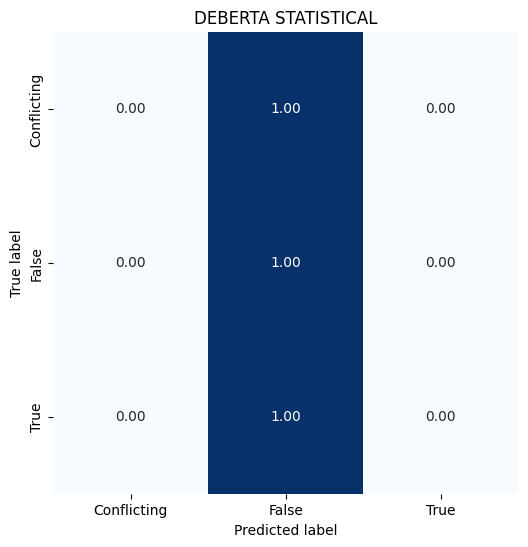

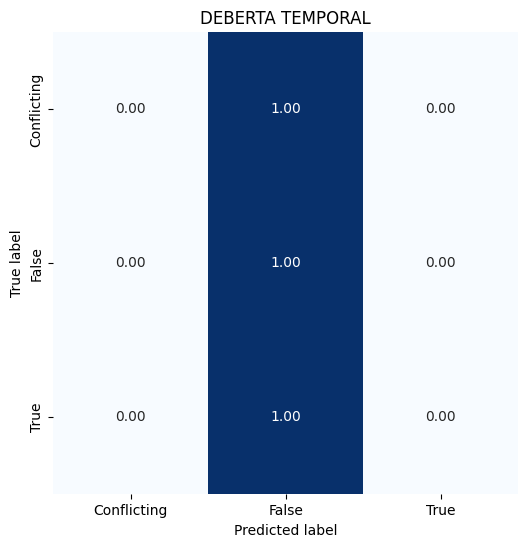

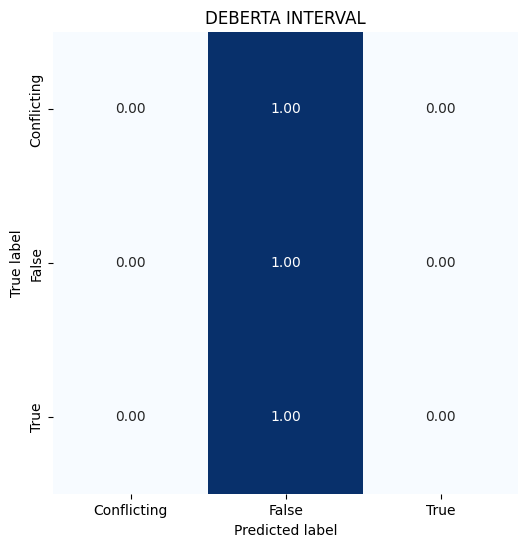

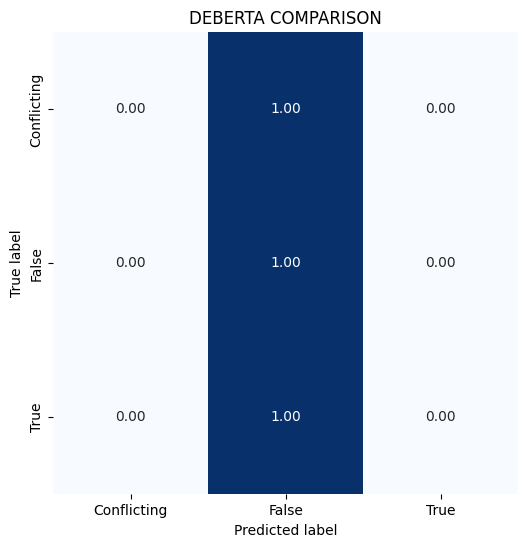

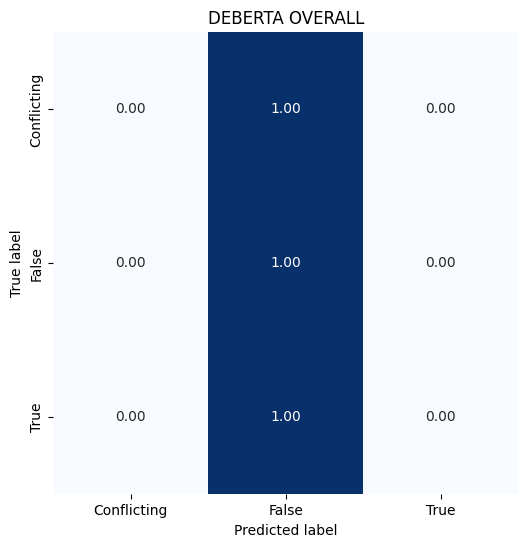

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, class_names, title):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    title (str): Title of the heatmap.
    """
    # Normalize the confusion matrix.
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6,6))  # Adjust to fit your needs
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', cbar=False, ax=ax,
                xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    plt.close()  # Close the plot to avoid direct output
    return fig

# Calculate confusion matrices and plot them
categories = ['statistical', 'temporal', 'interval', 'comparison', 'overall']
class_labels = ['Conflicting', 'False', 'True']

# Generate and save confusion matrix plots
for category in categories:
    true_labels = taxonomy_metrics[category]['true'] if category != 'overall' else overall_true_labels
    pred_labels = taxonomy_metrics[category]['pred'] if category != 'overall' else overall_predictions
    cm = confusion_matrix(true_labels, pred_labels, labels=[0, 1, 2])

    fig = plot_confusion_matrix(cm, class_labels, f'{NAME_OF_MODEL.upper()} {category.upper()}')
    fig.savefig(f'/content/drive/MyDrive/TUDelft/NLP Group Project/{NAME_OF_MODEL}-outputs/confusion_matrices/{NAME_OF_MODEL}_{category}_confusion_matrix.png')  # Save the figure


In [ ]:
from collections import Counter

# Assuming overall_true_labels and overall_predictions are populated
true_label_counts = Counter(overall_true_labels)
predicted_label_counts = Counter(overall_predictions)

# If using LabelEncoder to transform labels, ensure it's fitted as shown previously
label_mapping = list(LE.classes_)  # E.g., ['Conflicting', 'False', 'True']

# Print counts for true labels
print("Counts of each class in the test set:")
for label_index, count in true_label_counts.items():
    print(f"{label_mapping[label_index]}: {count}")

# Print counts for predicted labels
print("\nCounts of each class predicted by the model:")
for label_index, count in predicted_label_counts.items():
    print(f"{label_mapping[label_index]}: {count}")
